## Exploratory Data Analysis, Feature Selection
## Table of Contents:
* [0. Importing dependencies](#dependencies)
* [1. Setting up of the dataset](#1.0)
    * [1.1 Importing and merging of the dataset](#1.1)
    * [1.2 Filling of missing values](#1.2)
* [2. Exploratory Data Analysis](#2.0)
    * [2.1 Stationarity and seasonality](#2.1)
    * [2.2 Outliers](#2.2)
    * [2.3 Trends by week, month and show](#2.3)
    * [2.4 Correlation matrix and pairplots](#2.4)
* [3. Feature Selection](#3.0)
    * [3.1 PCA](#3.1)
    * [3.2 XGBoost](#3.2)

# 0. Importing dependencies  <a class="anchor" id="dependencies"></a>

In [1]:
# importing libraries
!pip install shap
import shap
import string
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import math
import os
import warnings
warnings.filterwarnings("ignore")
import chardet
from datetime import datetime, timedelta

#sklearn related modules
import xgboost as xgb
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.seasonal import seasonal_decompose
!pip install sktime
!pip install darts
import sktime
from darts import TimeSeries
from sktime.utils.plotting import plot_series
from darts.utils.statistics import check_seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss

!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

import platform
print(platform.python_version())

setting = 'RNN'
plt.style.use('seaborn')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.9 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 10.0 MB/s eta

# 1. Setting up of the dataset <a class="anchor" id="1.0"></a>

## 1.1 Importing and merging of the dataset <a class="anchor" id="1.1"></a>

In [2]:
activetv_impressions = pd.read_csv(f'../content/gdrive/My Drive/Colab Notebooks/{setting}/KanalD_data/Activetv_impressions/activetv_impressions.csv')
ratings = pd.read_csv(f'../content/gdrive/My Drive/Colab Notebooks/{setting}/KanalD_data/Rating/ratings.csv')

activetv_impressions_ratings=activetv_impressions.merge(ratings, on='DateTime', how='left') #some ratings data are missing
activetv_impressions_ratings.head()

,Viewership,DateTime,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Tunein,Tuneout,Rating,Share
0,106442,2022-01-01 00:00:00,0,0,1,0,0,0,0,38235,NaN,5.97,14.12
1,89895,2022-01-01 00:01:00,0,0,1,0,0,0,0,27579,44126.0,5.16,12.27
2,96484,2022-01-01 00:02:00,0,0,1,0,0,0,0,24859,18270.0,5.34,12.80
3,100741,2022-01-01 00:03:00,0,0,1,0,0,0,0,31865,27608.0,5.52,13.39
4,113945,2022-01-01 00:04:00,0,0,1,0,0,0,0,26877,13673.0,6.28,15.34


## 1.2 Filling of missing values <a class="anchor" id="1.2"></a>

In [3]:
# Install the forecast package if not already installed
robjects.r('install.packages("forecast")')

# Import the forecast package
forecast = robjects.packages.importr("forecast")

# Define the columns of interest
columns = ['Viewership', 'Tunein', 'Tuneout', 'Rating', 'Share']

# Initialize an empty dictionary to store cleaned data for each column
cleaned_data_dict = {}

# Iterate over each column
for column in columns:
    # Convert the column data to numeric format
    data = activetv_impressions_ratings[column].tolist()

    # Convert Python list to R vector
    r_vector = robjects.FloatVector(data)

    # Apply tsclean for time series cleaning
    cleaned_data = forecast.tsclean(r_vector)

    # Convert the R cleaned_data to a Python object
    cleaned_data_python = robjects.conversion.rpy2py(cleaned_data)

    # Convert cleaned data to a Python list
    cleaned_data_list = list(cleaned_data_python)

    # Store the cleaned data in the dictionary with the column name as the key
    cleaned_data_dict[column] = cleaned_data_list

# Merge the cleaned data into a DataFrame
df_cleaned = pd.DataFrame(cleaned_data_dict)

# Print the cleaned data DataFrame
#print(df_cleaned)


(as ‘lib’ is unspecified)





































































	‘/tmp/RtmpviZIwg/downloaded_packages’



In [4]:
# # Define the columns of interest
# columns = ['Viewership', 'Tunein', 'Tuneout', 'Rating', 'Share']

# # Initialize an empty dictionary to store cleaned data for each column
# cleaned_data_dict = {}

# # Iterate over each column
# for column in columns:
#     # Extract the column data
#     data = activetv_impressions_ratings[column]

#     # Perform linear interpolation to fill in missing values
#     cleaned_data = data.interpolate(method='linear')

#     # Store the cleaned data in the dictionary with the column name as the key
#     cleaned_data_dict[column] = cleaned_data

# # Merge the cleaned data into a DataFrame
# df_cleaned = pd.DataFrame(cleaned_data_dict)

# # Print the cleaned data DataFrame
# print(df_cleaned)

In [5]:
#activetv_impressions_ratings_filled = activetv_impressions_ratings.fillna(method='bfill')

activetv_impressions_ratings[['Viewership', 'Tunein', 'Tuneout', 'Rating', 'Share']] = df_cleaned.values
activetv_impressions_ratings.head()

,Viewership,DateTime,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Tunein,Tuneout,Rating,Share
0,106442.0,2022-01-01 00:00:00,0,0,1,0,0,0,0,10964.0,10019.0,4.06,14.12
1,89895.0,2022-01-01 00:01:00,0,0,1,0,0,0,0,10964.0,10019.0,4.06,12.27
2,96484.0,2022-01-01 00:02:00,0,0,1,0,0,0,0,10964.0,10019.0,4.06,12.80
3,100741.0,2022-01-01 00:03:00,0,0,1,0,0,0,0,10964.0,10019.0,4.06,13.39
4,113945.0,2022-01-01 00:04:00,0,0,1,0,0,0,0,10964.0,10019.0,4.06,15.34


In [6]:
activetv_impressions_ratings_filled=activetv_impressions_ratings.copy()
activetv_impressions_ratings_filled.info()
activetv_impressions_ratings_filled['DateTime'] = pd.to_datetime(activetv_impressions_ratings_filled['DateTime'])
activetv_impressions_ratings_filled.set_index('DateTime', inplace=True)
activetv_impressions_ratings_filled.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698400 entries, 0 to 698399
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Viewership  698400 non-null  float64
 1   DateTime    698400 non-null  object 
 2   Friday      698400 non-null  int64  
 3   Monday      698400 non-null  int64  
 4   Saturday    698400 non-null  int64  
 5   Sunday      698400 non-null  int64  
 6   Thursday    698400 non-null  int64  
 7   Tuesday     698400 non-null  int64  
 8   Wednesday   698400 non-null  int64  
 9   Tunein      698400 non-null  float64
 10  Tuneout     698400 non-null  float64
 11  Rating      698400 non-null  float64
 12  Share       698400 non-null  float64
dtypes: float64(5), int64(7), object(1)
memory usage: 74.6+ MB


,Viewership,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Tunein,Tuneout,Rating,Share
DateTime,,,,,,,,,,,,
2022-01-01 00:00:00,106442.0,0,0,1,0,0,0,0,10964.0,10019.0,4.06,14.12
2022-01-01 00:01:00,89895.0,0,0,1,0,0,0,0,10964.0,10019.0,4.06,12.27
2022-01-01 00:02:00,96484.0,0,0,1,0,0,0,0,10964.0,10019.0,4.06,12.80
2022-01-01 00:03:00,100741.0,0,0,1,0,0,0,0,10964.0,10019.0,4.06,13.39
2022-01-01 00:04:00,113945.0,0,0,1,0,0,0,0,10964.0,10019.0,4.06,15.34


# 2. Exploratory Data Analysis  <a class="anchor" id="2.0"></a>

## 2.1 Stationarity and seasonality <a class="anchor" id="2.1"></a>

In [7]:
def check_stationary(variable,df):
   ts = np.array(df[variable].resample('D').mean().values, dtype=np.float32)

  # # Dickey-Fuller test
   result = adfuller(ts, autolag='AIC')
   print('Variable: ' , variable)
   print('ADF - Test statistic: ' , result[0])
   print('ADF - p-value: {:.10f}'.format(result[1]))
   print('ADF - Critical Values:' ,result[3])

for x in ['Viewership','Tunein', 'Tuneout','Rating', 'Share']:
  check_stationary(x,activetv_impressions_ratings_filled)

Variable:  Viewership
ADF - Test statistic:  -2.2001054656909558
ADF - p-value: 0.2062071811
ADF - Critical Values: 470
Variable:  Tunein
ADF - Test statistic:  -2.493530894787121
ADF - p-value: 0.1170562728
ADF - Critical Values: 467
Variable:  Tuneout
ADF - Test statistic:  -2.431860690243644
ADF - p-value: 0.1329451121
ADF - Critical Values: 466
Variable:  Rating
ADF - Test statistic:  -2.298415584838379
ADF - p-value: 0.1724794862
ADF - Critical Values: 470
Variable:  Share
ADF - Test statistic:  -2.774198271143533
ADF - p-value: 0.0620549271
ADF - Critical Values: 467


In [8]:
# Perform seasonal decomposition for each variable and plot the components
def plot_seasonal(variable,df):
  # Set up the subplots
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20, 15))
    # Extract the time series data for the current variable
    ts = df[variable]
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(ts, period=1440*7)  # Assuming daily seasonality with 1440 minutes in a day

    # Access the decomposition components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot the components in the subplots
    axs[0].plot(ts)
    axs[1].plot(trend)
    axs[2].plot(seasonal)
    axs[3].plot(residual)

    # Set titles and legends for each subplot
    axs[0].set_title(f"{variable} - Actual")
    axs[1].set_title(f"{variable} - Trend")
    axs[2].set_title(f"{variable} - Seasonal")
    axs[3].set_title(f"{variable} - Residual")

    for j in range(4):
        axs[j].set_xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-01-31'))

    # Add green dotted vertical lines for daily ticks
    daily_ticks = pd.date_range(start='2023-01-01', end='2023-01-31', freq='D')
    for k, tick in enumerate(daily_ticks):
        if k % 7 == 0:
            color = 'red'
        else:
            color = 'green'
        axs[0].axvline(x=tick, color=color, linestyle='dotted')
        axs[1].axvline(x=tick, color=color, linestyle='dotted')
        axs[2].axvline(x=tick, color=color, linestyle='dotted')
        axs[3].axvline(x=tick, color=color, linestyle='dotted')
    plt.tight_layout()
    # Show the plot
    plt.show()




In [9]:
# Check seasonality at different levels for each column
def check_wkseasonal(variable,df):
    ts=TimeSeries.from_values(df[variable].resample('D').mean().values)
    # Check seasonality
    is_seasonal, periodicity = check_seasonality(ts, m=7)
    dict_seas = {
        "variable":variable,
        "is seasonal?": is_seasonal,
        "periodicity": f'{periodicity}',
    }
    _ = [print(k, ":", v) for k, v in dict_seas.items()]

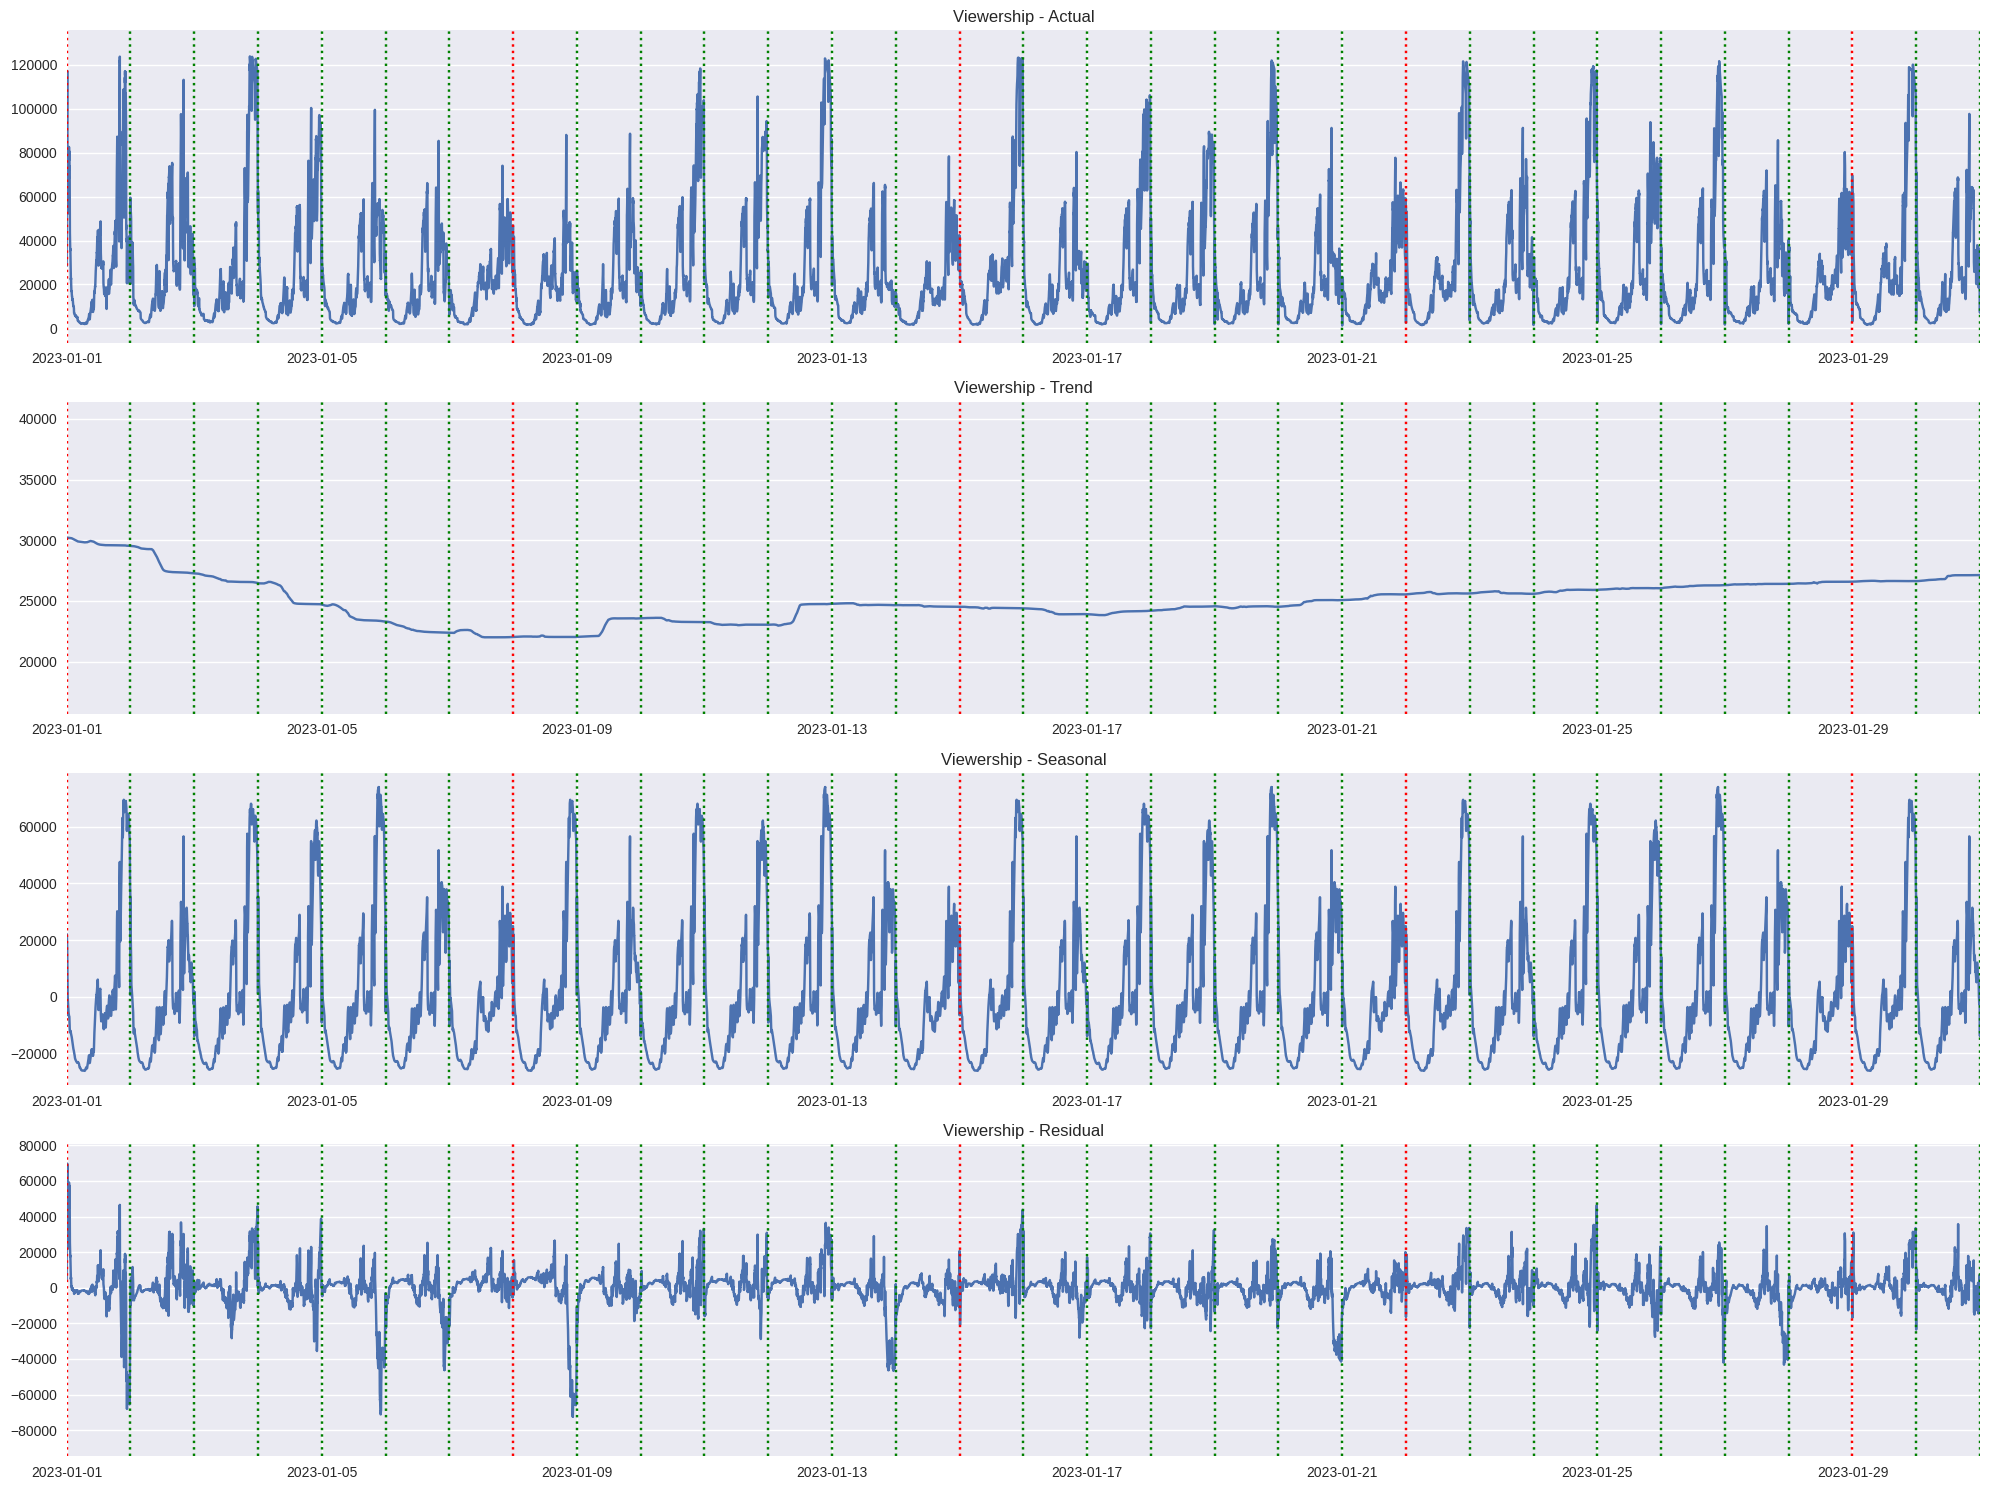

In [10]:
#for x in ['Viewership','Tunein', 'Tuneout','Rating', 'Share']:
for x in ['Viewership']:
  plot_seasonal(x,activetv_impressions_ratings_filled)
  #check_wkseasonal(x,activetv_impressions_ratings_filled)

In [11]:
shows = pd.read_csv(f'../content/gdrive/My Drive/Colab Notebooks/{setting}/KanalD_data/Show/shows.csv')

df_final=shows.merge(activetv_impressions_ratings, on='DateTime', how='left') #using shows for prediction

print(df_final.columns)

df_final = df_final[df_final['Show'] == 1]
df_final = df_final[['DateTime', 'Viewership','Tunein', 'Tuneout','Rating', 'Share', 'NormEps', 'Show Name','Show',
                         'genre_Action', 'genre_Comedy', 'genre_Crime', 'genre_Drama', 'genre_Medical', 'genre_Police', 'genre_Romance', 'genre_Talk Show', 'genre_Thriller','genre_sketch',
                         'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
df_final = df_final.sort_values('DateTime', ascending=True).reset_index(drop=True)
df_final.head()
df_final.info()

Index(['DateTime', 'Show', 'Date', 'Show Name', 'Episode', 'Genre', 'Time',
       'Time Slot', 'Duration (m)', 'Writer', 'Director', 'Season', 'EpNo',
       'Eps', 'NormEps', 'StartDateTime', 'EndDateTime', 'genre_Action',
       'genre_Comedy', 'genre_Crime', 'genre_Drama', 'genre_Medical',
       'genre_Police', 'genre_Romance', 'genre_Talk Show', 'genre_Thriller',
       'genre_sketch', 'Viewership', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'Tunein', 'Tuneout', 'Rating',
       'Share'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40552 entries, 0 to 40551
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DateTime         40552 non-null  object 
 1   Viewership       40552 non-null  float64
 2   Tunein           40552 non-null  float64
 3   Tuneout          40552 non-null  float64
 4   Rating           40552 non-null  float64
 5   

In [12]:
null_rows = df_final[df_final.isnull().any(axis=1)]
print(null_rows)
df_final.loc[df_final['Tuneout'] < 0, 'Tuneout'] = 0

#df_final.dropna(inplace=True)

Empty DataFrame
Columns: [DateTime, Viewership, Tunein, Tuneout, Rating, Share, NormEps, Show Name, Show, genre_Action, genre_Comedy, genre_Crime, genre_Drama, genre_Medical, genre_Police, genre_Romance, genre_Talk Show, genre_Thriller, genre_sketch, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday]
Index: []

[0 rows x 26 columns]


## 2.2 Outliers <a class="anchor" id="2.2"></a>

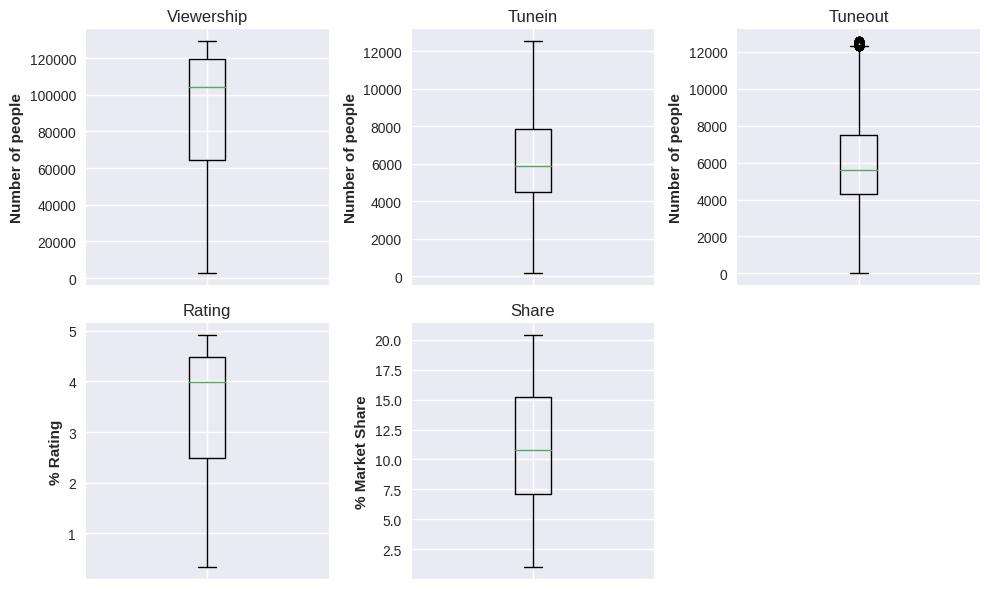

In [13]:
# create a 3x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
# plot the boxplots for each column
axs[0, 0].boxplot(df_final['Viewership'])
axs[0, 0].set_title('Viewership')
axs[0, 0].set_ylabel('Number of people')

axs[0, 1].boxplot(df_final['Tunein'])
axs[0, 1].set_title('Tunein')
axs[0, 1].set_ylabel('Number of people')

axs[0, 2].boxplot(df_final['Tuneout'])
axs[0, 2].set_title('Tuneout')
axs[0, 2].set_ylabel('Number of people')

axs[1, 0].boxplot(df_final['Rating'])
axs[1, 0].set_title('Rating')
axs[1, 0].set_ylabel('% Rating')

axs[1, 1].boxplot(df_final['Share'])
axs[1, 1].set_title('Share')
axs[1, 1].set_ylabel('% Market Share')

fig.delaxes(axs[1, 2])

# remove tick labels on the x-axis for the bottom row
for ax in axs.flat:
    ax.set_xticklabels([])

# adjust the spacing between the subplots
plt.tight_layout()

# show the plot
plt.show()

In [14]:
# create a list of the variable names to iterate over
variables = ['Viewership', 'Tunein','Tuneout', 'Rating', 'Share']
outlier=[]

# iterate over each variable
for var in variables:
    # calculate the upper and lower bounds for outliers
    Q1 = df_final[var].quantile(0.25)
    Q3 = df_final[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # identify the indices of the outliers
    outliers = df_final[(df_final[var] < lower_bound) | (df_final[var] > upper_bound)].index
    outlier.extend([element for element in outliers if element not in outlier])

    # count the number of outliers
    num_outliers = len(outliers)

    # print the number of outliers
    print("Number of outliers in", var, ":", num_outliers, "out of", df_final.shape[0])

# remove the outliers from the DataFrame
#df_final = df_final.drop(outlier)
df_final.to_csv(f'../content/gdrive/My Drive/Colab Notebooks/{setting}/df_final.csv', index=False)


Number of outliers in Viewership : 0 out of 40552
Number of outliers in Tunein : 0 out of 40552
Number of outliers in Tuneout : 111 out of 40552
Number of outliers in Rating : 0 out of 40552
Number of outliers in Share : 0 out of 40552


## 2.3 Trends by week, month and show <a class="anchor" id="2.3"></a>

{'ARKA SOKAKLAR': 'A', 'CAMDAKİ KIZ': 'B', 'KRALİÇE': 'C', 'SADAKATSİZ': 'D', 'SEVERSİN': 'E', 'VEDA MEKTUBU': 'F', 'YARGI': 'G', 'ÇOK GÜZEL HAREKETLER 2': 'H', 'ÜÇ KIZ KARDEŞ': 'I', 'ŞARKILAR BİZİ SÖYLER': 'J'}


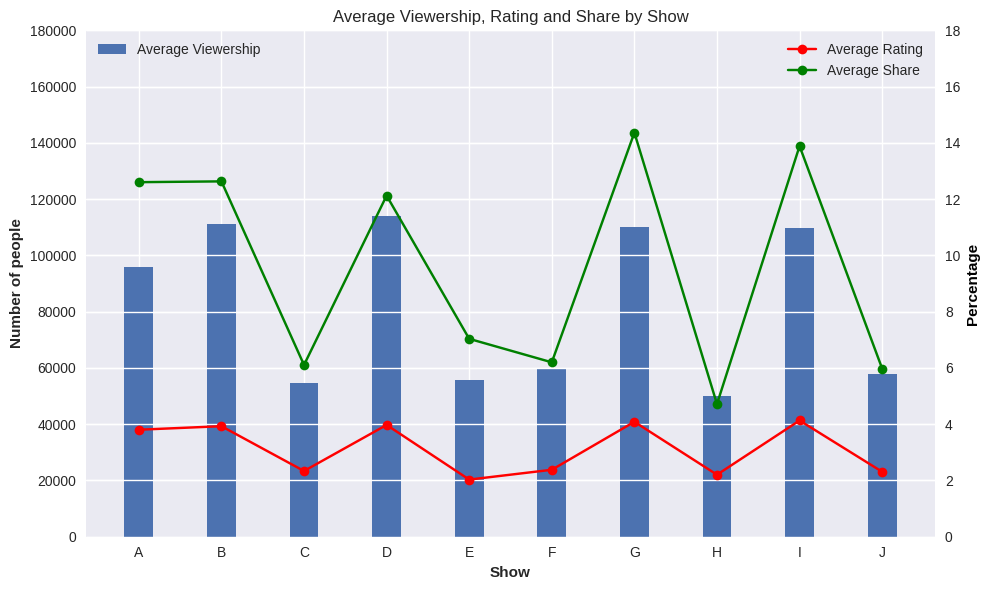

In [15]:
# Group by show and calculate the average viewership, 'KANALD-RTG', and 'KANALD-SHR'
average_viewership = df_final[df_final['Show'] == 1].groupby('Show Name')['Viewership'].mean()
average_rtg = df_final[df_final['Show'] == 1].groupby('Show Name')['Rating'].mean()
average_shr = df_final[df_final['Show'] == 1].groupby('Show Name')['Share'].mean()

# Sort the shows in alphabetical order
average_viewership = average_viewership.sort_index()
average_rtg = average_rtg.sort_index()
average_shr = average_shr.sort_index()

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Generate show labels dynamically
num_shows = len(average_viewership.index)
show_labels = list(string.ascii_uppercase)[:num_shows]  # A, B, C, ..., J

# Create a dictionary mapping original show names to new labels
label_mapping = dict(zip(average_viewership.index, show_labels))
print(label_mapping)
# Plot average viewership on the left y-axis as a bar plot
bar_width = 0.35
x = range(len(average_viewership))
ax1.bar(x, average_viewership.values, width=bar_width, label='Average Viewership')
ax1.set_xlabel('Show')
ax1.set_ylabel('Number of people')
ax1.set_ylim([0, 180000])

# Set the x-axis tick positions and labels
ax1.set_xticks(x)
ax1.set_xticklabels([label_mapping[show_name] for show_name in average_viewership.index])
ax1.tick_params(axis='x', width=bar_width)

# Create a twin axis sharing the x-axis
ax2 = ax1.twinx()

# Plot average RTG on the right y-axis as a line plot
ax2.plot(x, average_rtg.values, color='red', marker='o', linestyle='-', label='Average Rating')
ax2.set_ylim([0, 18])

# Plot average SHR on the right y-axis as a line plot
ax2.plot(x, average_shr.values, color='green', marker='o', linestyle='-', label='Average Share')
ax2.set_ylabel('Percentage', color='black')

# Set the width of the x-axis ticks for both axes to be the same
ax2.tick_params(axis='x', width=bar_width)

# Set the title and legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Average Viewership, Rating and Share by Show')

# Set the y-axis tick positions and labels for ax1
yticks_ax1 = np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 10).astype(int)
ax1.set_yticks(yticks_ax1)
ax1.set_yticklabels(yticks_ax1)

# Set the y-axis tick positions and labels for ax2
yticks_ax2 = np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 10).astype(int)
ax2.set_yticks(yticks_ax2)
ax2.set_yticklabels(yticks_ax2)

# Show the plot
plt.tight_layout()
plt.show()


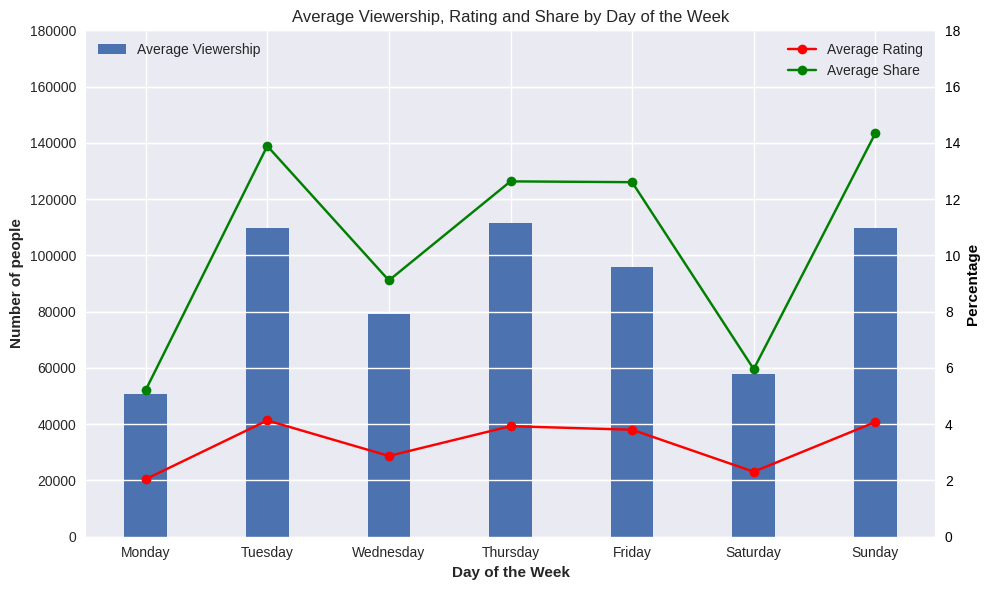

In [16]:
# Group by day of the week and calculate the average viewership, 'KANALD-RTG', and 'KANALD-SHR'
average_viewership = df_final.groupby(pd.to_datetime(df_final['DateTime']).dt.day_name())['Viewership'].mean()
average_rtg = df_final.groupby(pd.to_datetime(df_final['DateTime']).dt.day_name())['Rating'].mean()
average_shr = df_final.groupby(pd.to_datetime(df_final['DateTime']).dt.day_name())['Share'].mean()

# Sort the days of the week in the correct order
average_viewership = average_viewership.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
average_rtg = average_rtg.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
average_shr = average_shr.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average viewership on the left y-axis as a bar plot
bar_width = 0.35
x = np.arange(len(average_viewership))
ax1.bar(x, average_viewership.values, width=bar_width, label='Average Viewership')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Number of people')
ax1.set_xticks(x)
ax1.set_xticklabels(average_viewership.index)
ax1.set_ylim([0, 180000])

# Create a twin axis sharing the x-axis
ax2 = ax1.twinx()

# Plot average RTG on the right y-axis as a line plot
ax2.plot(average_rtg.index, average_rtg.values, color='red', marker='o', linestyle='-', label='Average Rating')
ax2.set_ylabel('Average Rating', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim([0, 18])

# Plot average SHR on the right y-axis as a line plot
ax2.plot(average_shr.index, average_shr.values, color='green', marker='o', linestyle='-', label='Average Share')
ax2.set_ylabel('Percentage', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set the title and legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Average Viewership, Rating and Share by Day of the Week')

# Set the y-axis tick positions and labels for ax1
yticks_ax1 = np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 10).astype(int)
ax1.set_yticks(yticks_ax1)
ax1.set_yticklabels(yticks_ax1)

# Set the y-axis tick positions and labels for ax2
yticks_ax2 = np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 10).astype(int)
ax2.set_yticks(yticks_ax2)
ax2.set_yticklabels(yticks_ax2)

# Show the plot
plt.tight_layout()
plt.show()


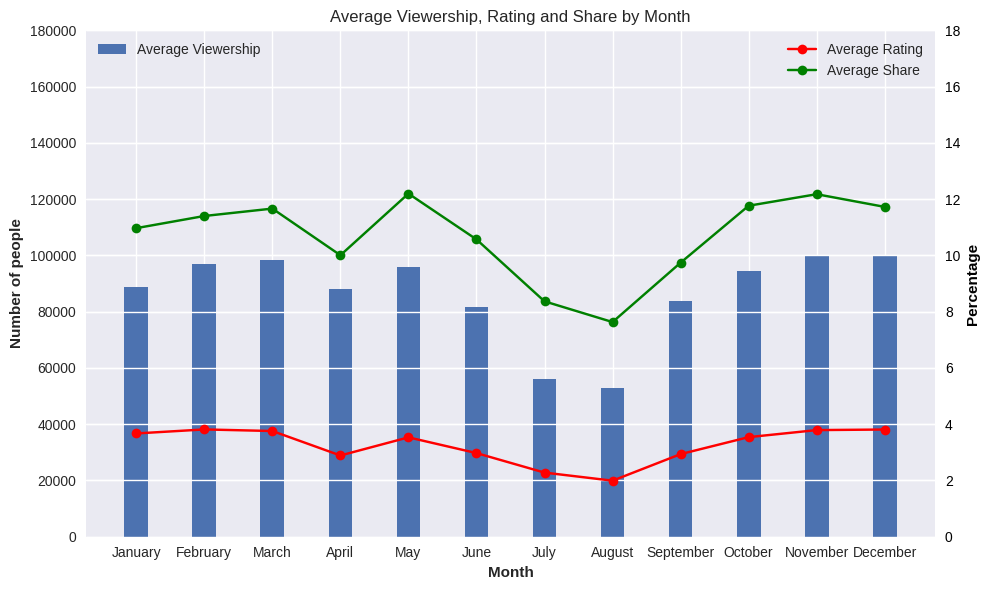

In [17]:
# Group by day of the week and calculate the average viewership, 'KANALD-RTG', and 'KANALD-SHR'
average_viewership = df_final.groupby(pd.to_datetime(df_final['DateTime']).dt.month_name())['Viewership'].mean()
average_rtg = df_final.groupby(pd.to_datetime(df_final['DateTime']).dt.month_name())['Rating'].mean()
average_shr = df_final.groupby(pd.to_datetime(df_final['DateTime']).dt.month_name())['Share'].mean()

# Sort the days of the week in the correct order
average_viewership = average_viewership.loc[[
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]]
average_rtg = average_rtg.loc[[
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]]
average_shr = average_shr.loc[[
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December"
]]

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average viewership on the left y-axis as a bar plot
bar_width = 0.35
x = np.arange(len(average_viewership))
ax1.bar(x, average_viewership.values, width=bar_width, label='Average Viewership')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of people')
ax1.set_xticks(x)
ax1.set_xticklabels(average_viewership.index)
ax1.set_ylim([0, 180000])

# Create a twin axis sharing the x-axis
ax2 = ax1.twinx()

# Plot average RTG on the right y-axis as a line plot
ax2.plot(average_rtg.index, average_rtg.values, color='red', marker='o', linestyle='-', label='Average Rating')
ax2.set_ylabel('Average Rating', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim([0, 18])

# Plot average SHR on the right y-axis as a line plot
ax2.plot(average_shr.index, average_shr.values, color='green', marker='o', linestyle='-', label='Average Share')
ax2.set_ylabel('Percentage', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set the title and legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Average Viewership, Rating and Share by Month')

# Set the y-axis tick positions and labels for ax1
yticks_ax1 = np.linspace(ax1.get_ybound()[0], ax1.get_ybound()[1], 10).astype(int)
ax1.set_yticks(yticks_ax1)
ax1.set_yticklabels(yticks_ax1)

# Set the y-axis tick positions and labels for ax2
yticks_ax2 = np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 10).astype(int)
ax2.set_yticks(yticks_ax2)
ax2.set_yticklabels(yticks_ax2)

# Show the plot
plt.tight_layout()
plt.show()


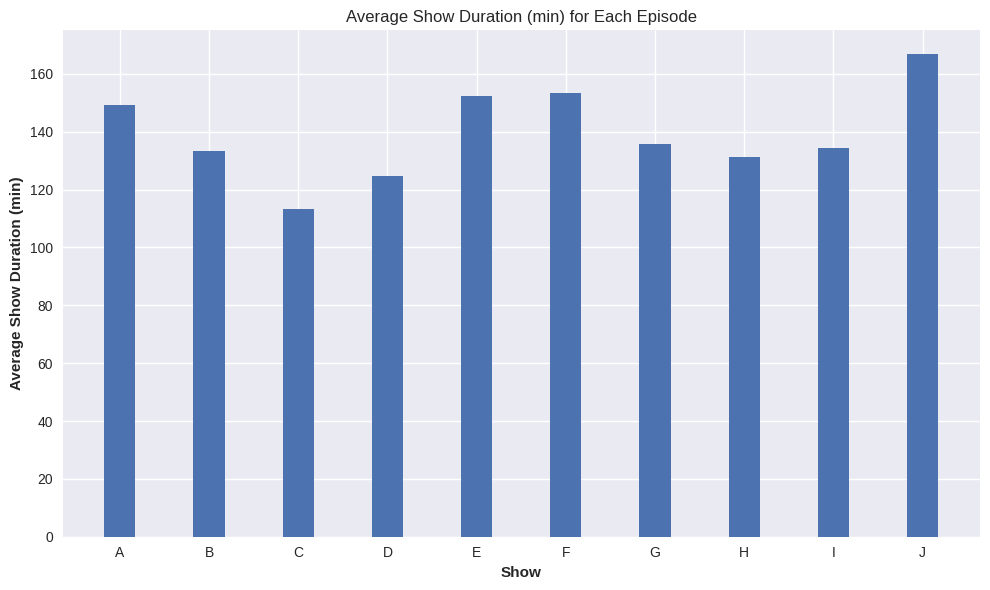

In [18]:
# Group by day and ShowName, and calculate the sum of 'Show' column for each group
df_final['Date'] = pd.to_datetime(df_final['DateTime']).dt.date

# Group by date and ShowName, and calculate the average of 'Show' column for each group
grouped = df_final.groupby(['Date', 'Show Name'])['Show'].sum().reset_index()

# Calculate the average of 'Show' column for each show
average_show = grouped.groupby('Show Name')['Show'].mean()

# Create a vertical bar plot for the average show values
show_labels = [label_mapping[show_name] for show_name in average_show.index]  # Get the actual show names from label mapping
plt.figure(figsize=(10, 6))  # Set the figure size to (10, 6)
plt.bar(show_labels, average_show.values,width=bar_width)
plt.xlabel('Show')
plt.ylabel('Average Show Duration (min)')
plt.title('Average Show Duration (min) for Each Episode')
plt.tight_layout()
plt.show()


## 2.4 Correlation matrix and pairplots <a class="anchor" id="2.4"></a>

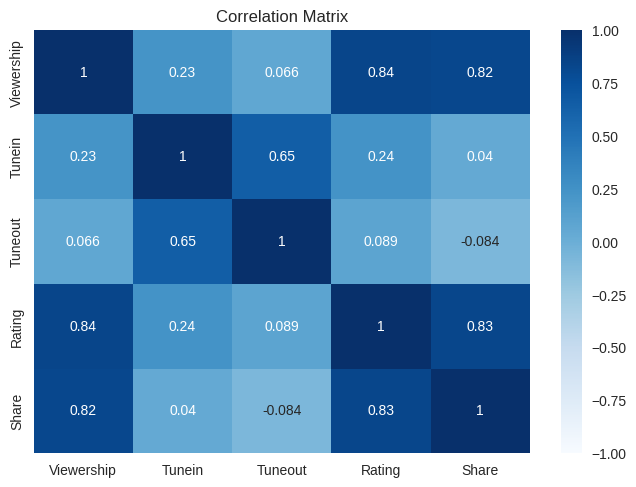

In [19]:
# Select the columns of interest
columns = ['Viewership', 'Tunein', 'Tuneout', 'Rating', 'Share']
df_new = df_final.set_index(pd.to_datetime(df_final['DateTime']))
selected_columns = df_new[columns]

# Create the correlation matrix
correlation_matrix = selected_columns.corr()

# Create a heatmap plot
sns.heatmap(correlation_matrix, annot=True, cmap='Blues',vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

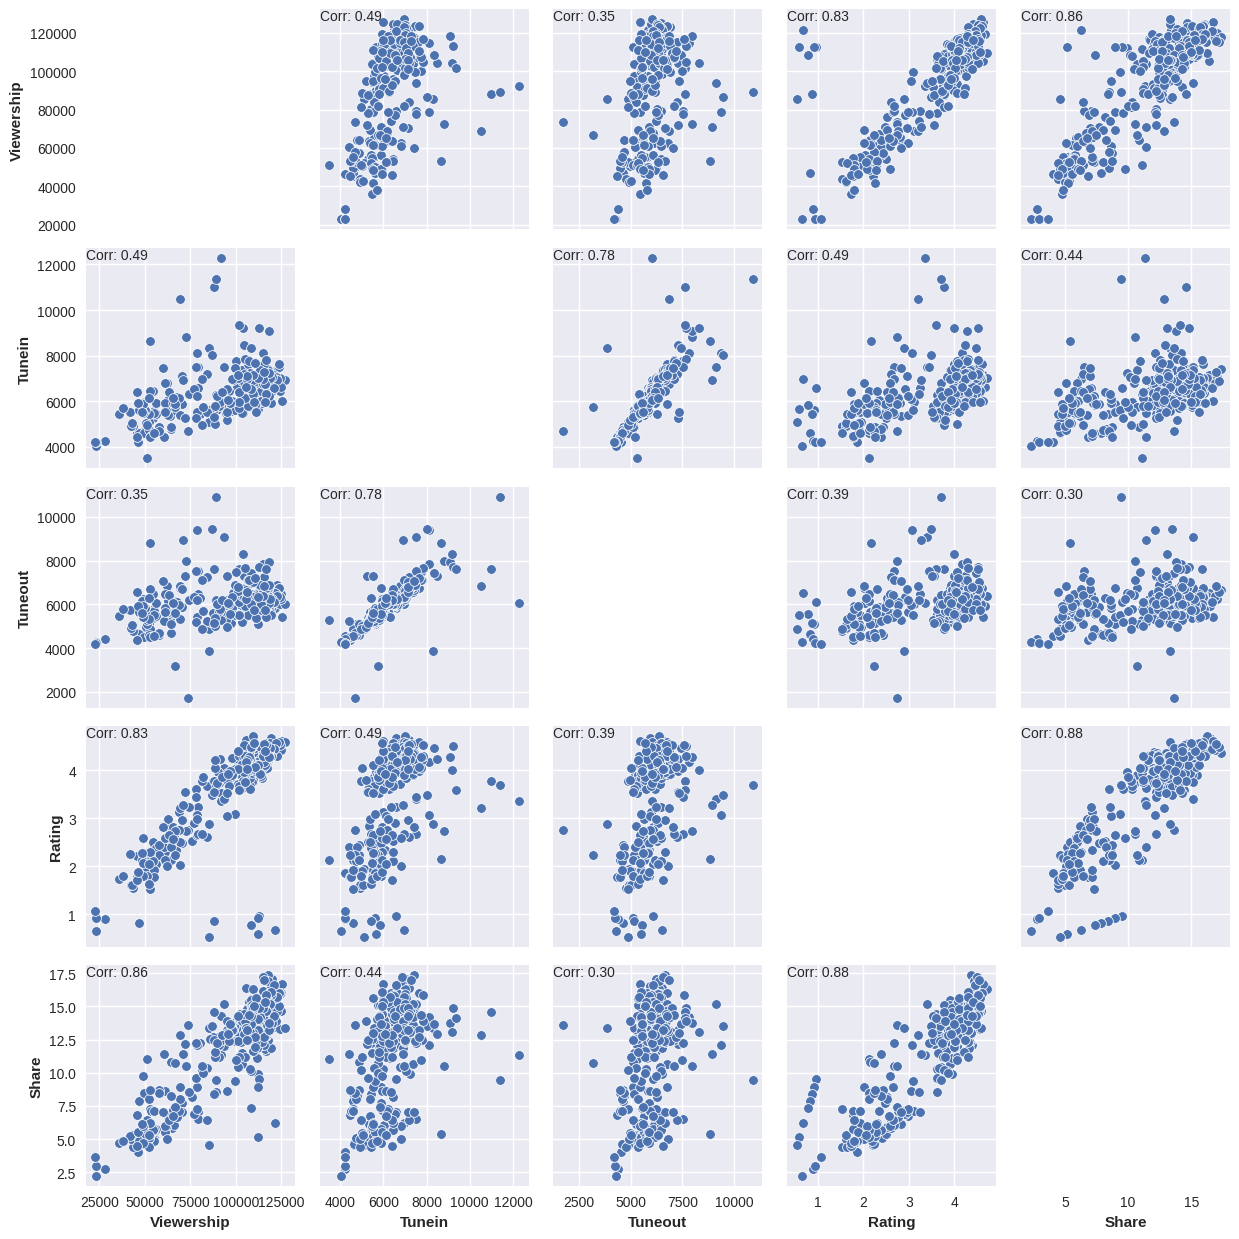

In [20]:
# Resample each column in selected_columns
resampled_columns = pd.DataFrame()
for column in selected_columns.columns:
    resampled_columns[column] = selected_columns[column].resample('D').mean()

# Create the pairplot
pairplot = sns.pairplot(resampled_columns)

# Iterate over column pairs to add titles and remove diagonal plots
for i, col_x in enumerate(resampled_columns.columns):
    for j, col_y in enumerate(resampled_columns.columns):
        if i != j:
            corr_value = resampled_columns[col_x].corr(resampled_columns[col_y])
            pairplot.axes[j, i].annotate(f'Corr: {corr_value:.2f}', (0, 1), xycoords='axes fraction', ha='left', va='top')
        else:
            pairplot.axes[i, i].set_facecolor('white')  # Set the facecolor of diagonal subplots to white
            for patch in pairplot.diag_axes[i].patches:
                patch.set_facecolor('white')
                patch.set_edgecolor('white')

plt.tight_layout()
plt.show()

In [21]:
#For own visualisation only

# fig, ax = plt.subplots(figsize=(50, 20))

# ax.plot(df_final.index, df_final["Viewership"], label="Viewership", color="red")
# ax.plot(df_final.index, df_final["Tunein"], label="Tunein", color="blue")
# ax.plot(df_final.index, df_final["Tuneout"], label="Tuneout", color="green")

# ax.set_title("Viewership, Tunein, Tuneout, over Time")
# ax.set_xlabel("Time Samples")
# ax.set_ylabel("Count")

# ax.legend()

# plt.show()

# 3. Feature Selection  <a class="anchor" id="3.0"></a>

## 3.1 PCA  <a class="anchor" id="3.1"></a>

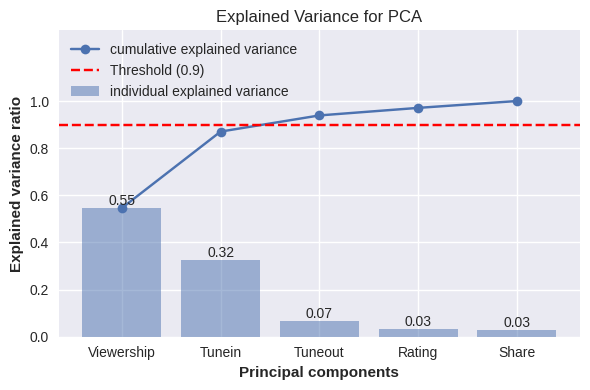

In [22]:
#df_final = df_final[['DateTime', 'Viewership','Tunein', 'Tuneout','KANALD-RTG', 'KANALD-SHR', 'NormEps',
 #                        'genre_Action', 'genre_Comedy', 'genre_Crime', 'genre_Drama', 'genre_Medical', 'genre_Police', 'genre_Romance', 'genre_Talk Show', 'genre_Thriller','genre_sketch',
  #                       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]




df_finals = df_final[['Viewership', 'Tunein', 'Tuneout', 'Rating', 'Share']]
feature_names=['Viewership', 'Tunein', 'Tuneout', 'Rating', 'Share']

# Step 1: Standardizing the data
X = df_finals.values
sc = StandardScaler()
X_std = sc.fit_transform(X)

# Step 2: Apply PCA
num_components = 5
pca = PCA(num_components)
X_pca = pca.fit_transform(X_std)

# Step 3: Determine the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Step 4: Plot explained variance ratio
plt.figure(figsize=(6, 4))
bars=plt.bar(range(num_components), explained_variance_ratio, alpha=0.5, align='center',
        label='individual explained variance')
plt.plot(range(num_components), cumulative_explained_variance,
         label='cumulative explained variance', marker='o')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(range(num_components), feature_names)
plt.title( "Explained Variance for PCA")
plt.ylim(0, 1.3)  # Set y-axis limits
plt.axhline(y=0.9, color='red', linestyle='--', label='Threshold (0.9)')
plt.legend(loc='upper left')
plt.yticks(np.arange(0, 1.1, 0.2))  # Set y-tick values
# Add value annotations to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



# legacy code
# # Step 4: Dimensionality Reduction
# pca = PCA()
# X_pca = pca.fit_transform(X_std)

# pca = PCA(n_components = 0.95)
# X_pca = pca.fit_transform(X_std) # this will fit and reduce dimensions
# print(pca.n_components_) # one can print and see how many components are selected. In this case it is 5 same as above we saw in step 5

# # Step 5: Plot cumulative explained variance ratio
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, num_components + 1),cumulative_explained_variance)
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.title('Cumulative Explained Variance for PCA')
# plt.xticks(range(1, num_components + 1))
# plt.tight_layout()
# plt.show()

# # Step 6: Finding the most important feature set
# n_pcs = pca.n_components_
# most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
# initial_feature_names = df_finals.columns
# most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# # Print the most important features
# print(most_important_names)


## 3.2 XGBoost  <a class="anchor" id="3.2"></a>

In [23]:
df_final =  pd.read_csv(f'../content/gdrive/My Drive/Colab Notebooks/{setting}/df_final.csv')

df_final = df_final[['Viewership','Tunein', 'Tuneout','Rating', 'Share',
                         'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

                                              #    'NormEps','genre_Action', 'genre_Comedy', 'genre_Crime', 'genre_Drama', 'genre_Medical', 'genre_Police', 'genre_Romance', 'genre_Talk Show', 'genre_Thriller','genre_sketch',

df_final.columns = df_final.columns.astype(str)

scaler = MinMaxScaler(feature_range=(0,1))

# Split data into training and testing sets
train_size = int(len(df_final) * 0.8)
df_train, df_test = df_final.iloc[:train_size], df_final.iloc[train_size:]

df_train['Rating'] = scaler.fit_transform(df_train[['Rating']])
df_train['Share'] = scaler.fit_transform(df_train[['Share']])
df_train['Tunein'] = scaler.fit_transform(df_train[['Tunein']])
df_train['Tuneout'] = scaler.fit_transform(df_train[['Tuneout']])
df_train['Viewership'] = scaler.fit_transform(df_train[['Viewership']])

df_test['Rating'] = scaler.fit_transform(df_test[['Rating']])
df_test['Share'] = scaler.fit_transform(df_test[['Share']])
df_test['Tunein'] = scaler.fit_transform(df_test[['Tunein']])
df_test['Tuneout'] = scaler.fit_transform(df_test[['Tuneout']])
df_test['Viewership'] = scaler.fit_transform(df_test[['Viewership']])

# Split predictor and target variables
X_train, y_train = df_train.drop('Viewership', axis=1), df_train['Viewership']
X_test, y_test = df_test.drop('Viewership', axis=1), df_test['Viewership']

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 6, 7, 8],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1]
}

# Create XGBoost model
model = xgb.XGBRegressor()

# Use GridSearchCV to find best hyperparameters
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring=mse_scorer, error_score='raise')
grid_search.fit(X_train, y_train,verbose=1)

# Print best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

# Train XGBoost model with best hyperparameters
best_model = xgb.XGBRegressor(**grid_search.best_params_)
best_model.fit(X_train, y_train)

Best hyperparameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

[[114439.09 ]
 [113342.1  ]
 [110984.42 ]
 ...
 [ 32542.287]
 [ 30449.639]
 [ 29775.205]]
[[115136.13333333]
 [114398.6       ]
 [113661.06666667]
 ...
 [ 33889.        ]
 [ 29882.        ]
 [ 27360.        ]]
Mean squared error: 127503374.23661134
Mean root squared error: 11291.739203356201


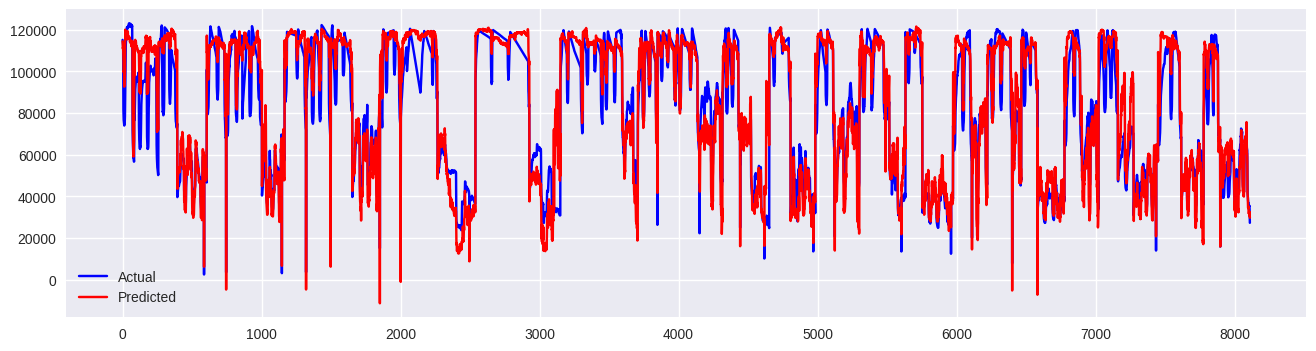

In [24]:

# Make predictions on scaled test set
predictions = best_model.predict(X_test)

# Unscale predictions
predictions = scaler.inverse_transform(predictions.reshape(-1,1))
print(predictions)
y_test_scaled = scaler.inverse_transform(y_test.to_numpy().reshape(-1,1))
print(y_test_scaled)
plt.style.use('seaborn')

# plotting
fig, ax = plt.subplots(figsize=(16,4))
plt.plot(y_test_scaled, color='blue', label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.legend()  # Add legend

# Evaluate model performance using MAE
mae = mean_squared_error(y_test_scaled, predictions)
print('Mean squared error:', mae)
print('Mean root squared error:', math.sqrt(mae))

 99%|===================| 8016/8111 [00:12<00:00]       

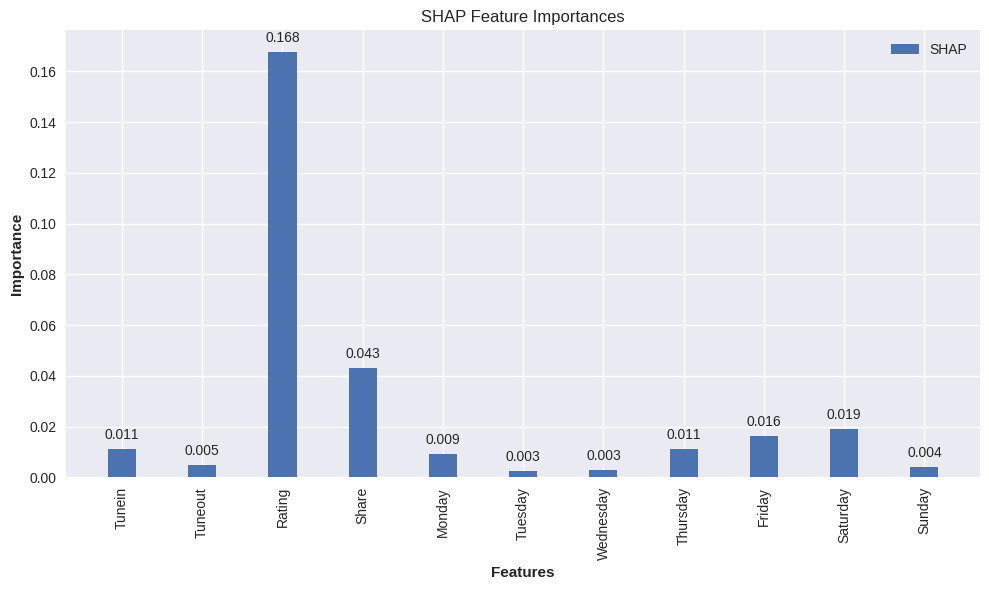

In [25]:
# Create an explainer object
explainer = shap.Explainer(best_model, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Get feature importance based on SHAP values
shap_feature_importance = np.abs(shap_values).mean(axis=0)

# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35

# Plot SHAP-based feature importances
shap_bars = ax.bar(np.arange(len(X_train.columns)), shap_feature_importance, bar_width, label='SHAP')

ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('SHAP Feature Importances')
ax.set_xticks(np.arange(len(X_train.columns)))
ax.set_xticklabels(X_train.columns, rotation='vertical')
ax.legend()

# Add annotations to the bars
for shap_bar in shap_bars:
    ax.annotate(f'{shap_bar.get_height():.3f}', (shap_bar.get_x() + shap_bar.get_width() / 2, shap_bar.get_height()),
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()
